# Mở đầu
Flower là một thư viện python được tạo ra nhằm đơn giản hóa các cài đặt giả lập Federated Learning đơn giản hơn.

# Tải các packages cần thiết

In [1]:
!pip install -q flwr["simulation"] tensorflow
!pip install -q flwr_datasets["vision"]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 11.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 M

# Import các thư viện cần thiết
Đặc biệt là thư viện flwr để tiến hành giả lập

In [2]:
from typing import Dict, List, Tuple

import tensorflow as tf

import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

from datasets import Dataset
from flwr_datasets import FederatedDataset

VERBOSE = 0

# Số client giả lập
NUM_CLIENTS = 100

# Cài đặt các hàm cần thiết

Đầu tiên chúng ta cần cài đặt một mô hình chung để các client có thể huấn luyện, ở đây sử dụng tensorflow.keras để cài đặt:

In [3]:
def get_model():
    """Constructs a simple model architecture suitable for MNIST."""
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )
    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

Tiếp đến chúng ta cần cài đặt một class FlowerCLient tượng chưng cho các client:

In [4]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainset, valset) -> None:
        # Khởi tạo client và các biến cần thiết như mô hình, tập huấn luyện và tập test cho client đó.
        self.model = get_model()
        self.trainset = trainset
        self.valset = valset

    def get_parameters(self, config):
        # Một hàm để trả về tham số hiện tại của mô hình
        return self.model.get_weights()

    def fit(self, parameters, config):
        # Hàm huấn luyện
        self.model.set_weights(parameters)
        self.model.fit(self.trainset, epochs=1, verbose=VERBOSE)
        return self.model.get_weights(), len(self.trainset), {}

    def evaluate(self, parameters, config):
        # Hàm đánh giá
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.valset, verbose=VERBOSE)
        return loss, len(self.valset), {"accuracy": acc}

Với mỗi client, chúng ta có thể thay đổi các tham số cho việc huấn luyện bằng biến config được truyền vào hàm fit và evaluate. Config là một dictionary.


Flower cho phép gải lập nhiều client trên một máy và các client này sẽ chia sẻ tài nguyên của máy. Điều này có thể dẫn đến quá tải tài nguyên của máy. Do đó Flower cung cấp một phương pháp giúp chỉ giả lập một client khi cần thiết đến nó để huấn luyện hay đánh giá mô hình. Bằng cách sử dụng một hàm client_fn và tạo một client với id xác định như sau

In [5]:
def get_client_fn(dataset: FederatedDataset):
    """Hàm Client_fn cần phải được đưa vào bên trong một hàm khác, để gọi đến mỗi lần tạo client
    """

    def client_fn(cid: str) -> fl.client.Client:
        # Extract partition for client with id = cid
        client_dataset = dataset.load_partition(int(cid), "train")

        # Now let's split it into train (90%) and validation (10%)
        client_dataset_splits = client_dataset.train_test_split(test_size=0.1)

        trainset = client_dataset_splits["train"].to_tf_dataset(
            columns="image", label_cols="label", batch_size=32
        )
        valset = client_dataset_splits["test"].to_tf_dataset(
            columns="image", label_cols="label", batch_size=64
        )

        # Create and return client
        return FlowerClient(trainset, valset).to_client()

    return client_fn

Chúng ta có thể tạo một hàm để thực hiện tổng hợp các kết quả đánh giá khác nhau trong một round thành một kết quả đánh giá duy nhất. Ở đây là hàm weighted_average, hàm này sẽ được truyền vào Strategy để tổng hợp đánh giá mỗi round

In [6]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

Bên cạnh việc đánh giá ở các client, chúng ta có thể thực hiện việc đánh giá trên tập đánh giá ở phía server nữa. Do đó chúng ta cần viết một hàm đánh giá phía server. Hàm này sẽ được đặt trong một hàm khác giống client_fn để có thể gọi lại ở mỗi round

In [8]:
def get_evaluate_fn(testset: Dataset):
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(testset, verbose=VERBOSE)
        return loss, {"accuracy": accuracy}

    return evaluate

# Tạo dữ liệu
Do dữ liệu ban đầu là dữ liệu tập chung nên để giả lập huấn luyện chúng ta phải thực hiện việc chia dữ liệu thành các tập dữ liệu con. Flower cũng cung cấp bộ dữ liệu đã được chia sẵn tuy nhiên nếu muốn chia một cách khác hay kiểm soát được các bộ dữ liệu thì phải viết lại hàm chia dữ liệu.

In [9]:
# Download MNIST dataset and partition it
mnist_fds = FederatedDataset(dataset="mnist", partitioners={"train": NUM_CLIENTS})
# Get the whole test set for centralised evaluation
centralized_testset = mnist_fds.load_full("test").to_tf_dataset(
    columns="image", label_cols="label", batch_size=64
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

# Khai báo các Strategy cần thiết và thực hiện chạy giả lập
Trước khi thực hiện chạy giả lập chúng ta cần thực hiện khai báo Strategy mà Server sẽ sử dụng. Strategy là cách mà server mà thực hiện việc tổng hợp cũng như chọn các mô hình để huấn luyện.

In [10]:
# Bật train mô hình bằng GPU
enable_tf_gpu_growth()

# Tạo Strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,  # Chọn 10% client cho mỗi vòng huấn luyện
    fraction_evaluate=0.05,  # Chọn 5% client cho mỗi vòng đánh giá
    min_fit_clients=10,  # Không chọn ít hơn 10 client cho mỗi round
    min_evaluate_clients=5,  # Không chọn ít hơn 5 client cho việc đánh giá
    min_available_clients=int(
        NUM_CLIENTS * 0.75
    ),  # Yêu cầu chờ ít nhất 75% client sẵn sàng trước khi thực hiện chọn client cho đánh giá
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=get_evaluate_fn(centralized_testset),
)

# Chúng ta có thể xác định tài nguyên được gán cho mỗi client
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(mnist_fds),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10), # thực hiện việc huấn luyện trong 10 round toàn cầu
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth
    },
)

INFO flwr 2024-02-23 14:43:01,946 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-23 14:43:05,401	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-23 14:43:09,265 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3923122176.0, 'memory': 7846244352.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3923122176.0, 'memory': 7846244352.0}
INFO flwr 2024-02-23 14:43:09,269 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-23 1

Các kết quả huấn luyện của từng round cũng như kết quả cuối cùngsẽ được lưu vào biến history. Do đó chúng ta có thể vẽ biểu đồ huấn luyện từ biến này

history.metrics_centralized = {'accuracy': [(0, 0.07429999858140945), (1, 0.6567000150680542), (2, 0.7785999774932861), (3, 0.8105999827384949), (4, 0.8118000030517578), (5, 0.7961999773979187), (6, 0.7842000126838684), (7, 0.7807999849319458), (8, 0.7925000190734863), (9, 0.8068000078201294), (10, 0.8281999826431274)]}


Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

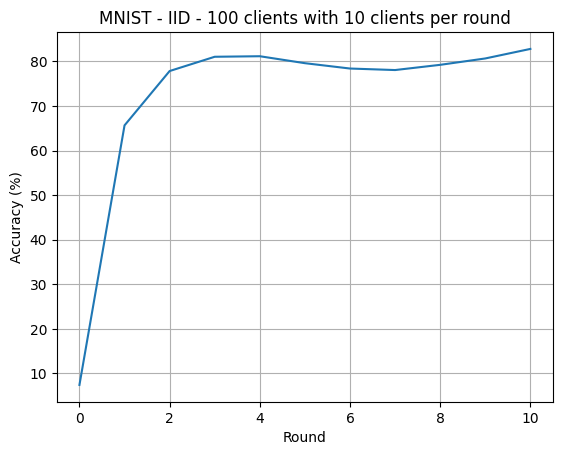

In [11]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")